In [24]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

## boxes可视化

In [13]:
# 随机生成颜色
import random
import itertools
import colorsys
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [2]:
random_colors(10)

[(0.0, 0.40000000000000036, 1.0),
 (0.0, 1.0, 1.0),
 (0.20000000000000018, 1.0, 0.0),
 (0.0, 1.0, 0.40000000000000036),
 (0.8000000000000007, 0.0, 1.0),
 (1.0, 0.0, 0.0),
 (1.0, 0.6000000000000001, 0.0),
 (1.0, 0.0, 0.5999999999999996),
 (0.7999999999999998, 1.0, 0.0),
 (0.1999999999999993, 0.0, 1.0)]

In [13]:
# 边框可视化
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
def display_boxes(image,boxes,class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")


    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

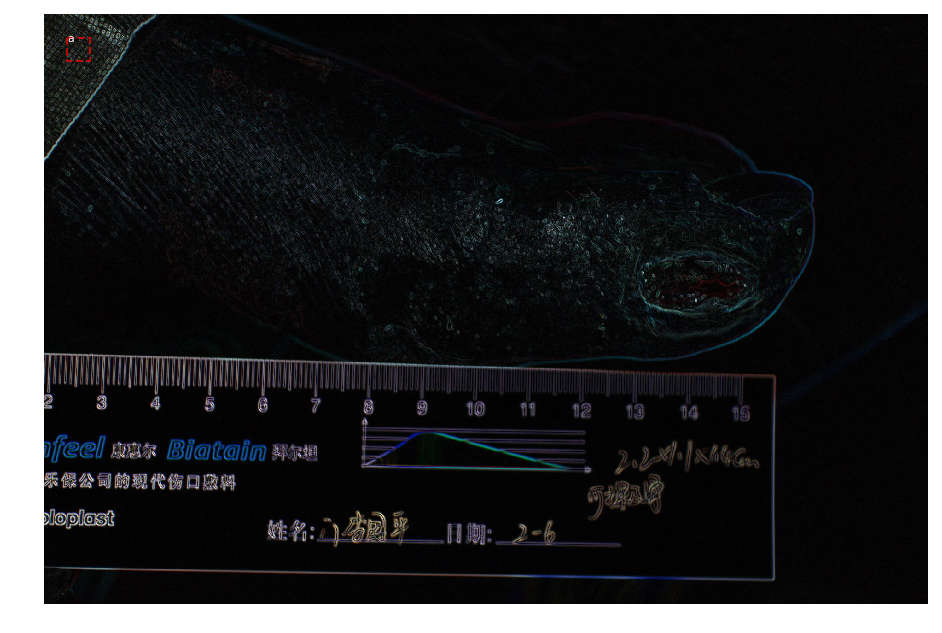

In [16]:
import numpy as np
image=plt.imread(r'D:\work\图像识别\医学影像\data_contour\IMG_6089.JPG')
display_boxes(image,np.array([[50,50,100,100]]),np.array([0]),np.array(['a']))

## mask可视化

In [10]:
import numpy as np
import matplotlib.pyplot as plt
def get_bit(byte_val, idx):
    return int((byte_val & (1 << idx)) != 0)


def shift_bit(byte_val, idx):
    return byte_val << idx if idx >= 0 else byte_val >> (-idx)


def bitor(a, b):
    return a | b

def make_color_map(num_classes):
    n = 256
    cmap = np.zeros((n, 3)).astype(np.int32)
    for i in range(0, n):
        d = i - 1
        r, g, b = 0, 0, 0
        for j in range(0, 7):
            r = bitor(r, shift_bit(get_bit(d, 0), 7 - j))
            g = bitor(g, shift_bit(get_bit(d, 1), 7 - j))
            b = bitor(b, shift_bit(get_bit(d, 2), 7 - j))
            d = shift_bit(d, -3)
        cmap[i, 0] = b
        cmap[i, 1] = g
        cmap[i, 2] = r
    return cmap[1:num_classes + 1]

In [11]:
make_color_map(4)

array([[  0,   0,   0],
       [  0,   0, 128],
       [  0, 128,   0],
       [  0, 128, 128]])

In [12]:
def predict_to_mask(pred, num_class):
    """
    将预测转为图像掩码
    :param pred: 二维numpy数组
    :return: numpy数组 (H,W,3)
    """
    color_map = make_color_map(num_class)

    # 生成预测的图像
    row, col = pred.shape
    # print("shape:{}".format(pred.shape))
    dst = np.tile(color_map[num_class - 1], (row, col, 1))
    for i in range(num_class):
        dst[pred == i] = color_map[i]
    return dst

In [6]:
def predict_to_mask(pred,num_class):
    """
    将预测转为图像掩码
    :param pred: 二维numpy数组
    :return:
    """
    color_map = make_color_map(num_class)

    # 生成预测的图像
    row, col = pred.shape
    # print("shape:{}".format(pred.shape))
    dst = np.tile(color_map[num_class - 1], (row, col, 1))
    for i in range(num_class):
        dst[pred == i] = color_map[i]
    return dst

In [8]:
def show_label_map(num_classes, cls_mapping):
    """
    展示不同类别的分割颜色
    :param num_classes:
    :param cls_mapping:
    :return:
    """
    lmap = make_color_map(num_classes)
    lmap = np.expand_dims(lmap, axis=1)
    plt.figure(figsize=(30, 10))
    plt.imshow(lmap.astype(np.uint8),interpolation='nearest')
    plt.yticks(range(num_classes), cls_mapping.keys())
    plt.xticks([], [])
    plt.grid('off')
    plt.show()

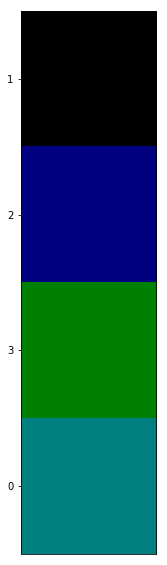

In [9]:
show_label_map(4,{1:'6',2:'7',3:'8',0:'bg'})

## 多边形可视化

In [33]:
def display_polygon(image, polygons, scores=None, figsize=(16, 16), ax=None, colors=None):
    auto_show = False
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True
    if colors is None:
        colors = random_colors(len(polygons))

    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')

    for i, polygon in enumerate(polygons):
        color = colors[i]
        polygon = np.reshape(polygon, (-1, 2))  # 转为[n,(x,y)]
        patch = patches.Polygon(polygon, facecolor=None, fill=False, color=color)
        ax.add_patch(patch)
        # 多边形得分
        x1, y1 = polygons[0][0], polygons[0][1]
        ax.text(x1, y1 + 8, scores[i] if scores is not None else '',
                color='w', size=11, backgroundcolor="none")
    if auto_show:
        plt.show()


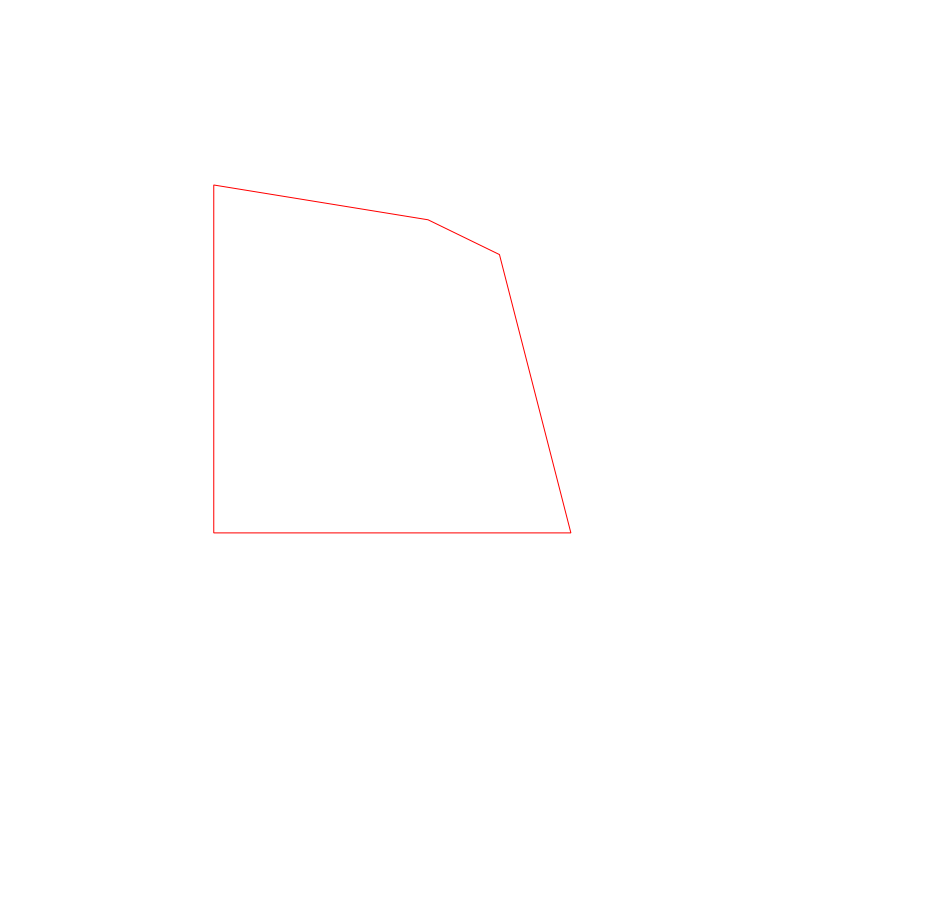

In [36]:
display_polygon(np.ones((30,30,3))*255, np.array([[0,1,1,1,0.8,0.2,0.6,0.1,0,0]])*20,[1,1,1,1,1])